In [1]:
import pandas as pd
import sklearn as skl
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

# Make sure to add NUS_datathon_team_10_files to MyDrive as shortcut
merged_path = "/content/drive/MyDrive/NUS_datathon_team_10_files/merged_data_eicu.csv"
df_merged = pd.read_csv(merged_path)

Mounted at /content/drive


### GAM

In [4]:
pd.set_option('display.max_columns', None)
df_merged.shape

(17437, 57)

In [5]:
confounders = ["age", "gender", "apsiii", "median_temp", "hosp_death", "temp_gap"]
for i in confounders:
  print(f'{i} : {df_merged[i].isnull().values.any()}')
subgroups = ["stroke", "sepsis", "cardiac_arrest", "age", "ethnicity", "tbi", "cns_infect"]
for i in subgroups:
  print(f'{i} : {df_merged[i].isnull().values.any()}')

print(f'There are {df_merged["ethnicity"].isna().sum()} NaN for Ethnicity')
print(f'There are {df_merged["apsiii"].isna().sum()} NaN for apsiii')

age : True
gender : True
apsiii : True
median_temp : False
hosp_death : False
temp_gap : False
stroke : False
sepsis : False
cardiac_arrest : False
age : True
ethnicity : True
tbi : False
cns_infect : False
There are 196 NaN for Ethnicity
There are 2162 NaN for apsiii


In [6]:
# Removing all nan values
nan_columns = ["age", "gender", "apsiii", "ethnicity"]
df_merged = df_merged.dropna(subset=nan_columns)
df_merged.shape

(15116, 57)

In [7]:
# How to deal with Unknown Gender. 
# Clean Unknown Gender
df_merged = df_merged[df_merged.gender != "Unknown"]

# Change Female and Male to 0 and 1
df_merged["gender"] = df_merged.gender.astype("category").cat.codes

<ipython-input-7-613eec63f07b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged["gender"] = df_merged.gender.astype("category").cat.codes


In [8]:
new_label = {"hosp_death": {"Expired": 1, "Alive": 0}}
df_merged.replace(new_label , inplace = True)

In [10]:
df_merged.shape

(15112, 57)

In [19]:
# df_merged = df_merged[df_merged["median_temp"] >= 28]
# df_merged[df_merged["median_temp"] < 26].count()
# df_merged.head()

,patientunitstayid,max_temp,min_temp,temp_gap,median_temp,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hosp_los_min,hosp_los_hour,hosp_los_days,hospitaldischargelocation,hosp_death,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,bmi,unitdischargetime24,icu_los_min,icu_los_hour,icu_los_days,unitdischargelocation,icu_death,uniquepid,cardiac_arrest,atrial_fibrillation,cancer,chf,ckd,cld,copd,diabetes,hypertension,ihd,sepsis,stroke,apsiii,dialysis,ventilation,vasopressor,aki,tbi,cns_infect
0,975436,37.8,36.6,1.2,36.8,718998,0,88.0,Caucasian,181,428,"Cancer, pancreatic",167.60,13:44:00,-14252,NaN,2015,18:46:00,3330,55.50,2.31,Death,1,Med-Surg ICU,11:16:00,Floor,1,admit,52.61,NaN,19.0,1:05:00,829,13.82,0.58,Floor,Alive,007-1357,0,0,0,0,0,0,0,0,0,0,0,0,52.0,0,0,0,0,0,0
1,975510,37.2,35.2,2.0,36.6,719056,1,61.0,Caucasian,181,428,"Pneumonia, other",170.18,21:27:00,-1720,Other ICU,2015,6:10:00,8883,148.05,6.17,Death,1,Med-Surg ICU,2:07:00,Other ICU,1,admit,49.40,61.40,17.0,6:10:00,8883,148.05,6.17,Death,Expired,007-13251,0,0,0,0,0,0,1,0,0,0,0,0,54.0,0,1,0,0,0,0
3,975761,37.2,20.2,17.0,35.8,719257,0,51.0,Caucasian,181,425,"Sepsis, renal/UTI (including bladder)",167.60,10:56:00,-431,Direct Admit,2015,22:46:00,8919,148.65,6.19,Home,0,Cardiac ICU,18:07:00,Direct Admit,1,admit,122.70,107.96,44.0,21:17:00,3070,51.17,2.13,Floor,Alive,007-2859,0,0,0,0,0,0,0,0,0,0,1,0,77.0,0,0,1,1,0,0
4,975838,37.8,37.4,0.4,37.6,719319,0,60.0,Caucasian,181,428,"Hemorrhage/hematoma-intracranial, surgery for",172.72,10:24:00,-269,Recovery Room,2015,14:10:00,14357,239.28,9.97,Other External,0,Med-Surg ICU,14:53:00,Recovery Room,1,admit,46.36,48.50,16.0,1:29:00,7836,130.60,5.44,Floor,Alive,007-12718,0,0,1,0,0,0,0,0,0,0,0,0,50.0,0,1,0,0,0,0
5,975867,36.4,32.8,3.6,34.2,719347,1,53.0,African American,181,428,Cardiac arrest (with or without respiratory ar...,182.90,13:35:00,-242,Emergency Department,2015,21:55:00,99618,1660.30,69.18,Skilled Nursing Facility,0,Med-Surg ICU,17:37:00,Emergency Department,1,admit,110.00,93.60,33.0,21:04:00,93807,1563.45,65.14,Telemetry,Alive,007-810,1,0,0,0,0,0,0,0,0,0,0,0,91.0,0,1,1,0,0,0


### GAM

In [2]:
!pip install pygam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 6.2 MB/s 


In [35]:
y_train=df_merged["hosp_death"].to_frame()
y_train.shape

(15112, 1)

In [59]:
X= df_merged[["median_temp","temp_gap", "age","gender","apsiii"]]
X.shape

(15112, 5)

In [56]:
from pygam import LogisticGAM, s, l, f
gam = LogisticGAM(terms=(s(0, n_splines = 8) + s(1, n_splines = 6) + l(2) + f(3) + l(4))).fit(X, y_train)
X["median_temp"].min()

14.1

In [42]:
# gam.summary()
print(type(gam))

<class 'pygam.pygam.LogisticGAM'>


<Figure size 432x288 with 0 Axes>

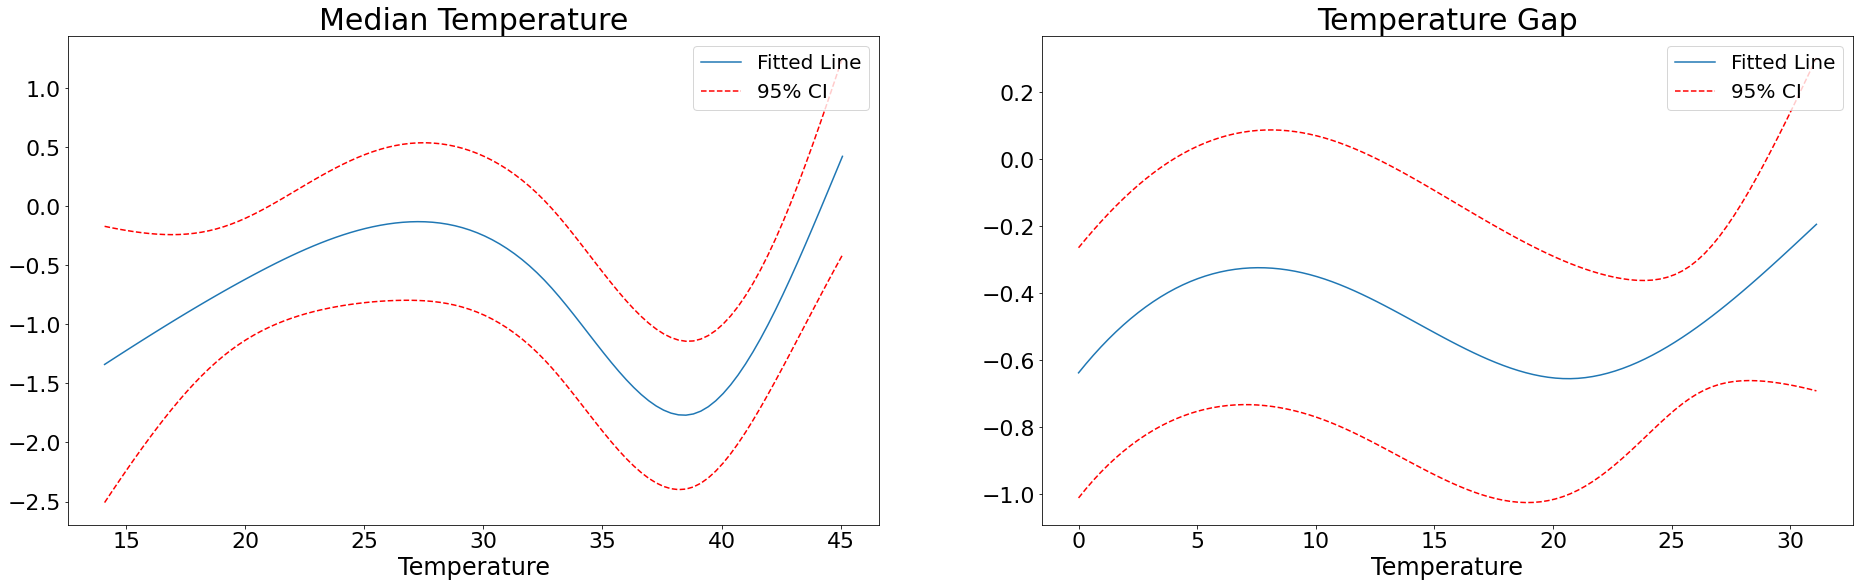

In [63]:
from matplotlib import pyplot as plt

plt.figure();
fig, axs = plt.subplots(1,2);
fig.set_figwidth(32)
fig.set_figheight(9)

titles = ["Median Temperature","Temperature Gap"]
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i], fontsize=30)
    ax.set_xlabel('Temperature', size=24)
    ax.tick_params(axis="x", labelsize=22)
    ax.tick_params(axis="y", labelsize=22)
    ax.legend(["Fitted Line", "95% CI"], loc="upper right", prop={'size': 20})

fig.align_labels()
plt.savefig(f'/content/drive/MyDrive/NUS_datathon_team_10_files/Graphs/eICU General.png')

In [76]:
#add in within temp range
count = lambda x: x.count()
count.__name__ = 'count'
agg_temp_range = {
    "within_range": [np.sum, count]
}
df_merged_agg_temp_range = df_merged.groupby('patientunitstayid').agg(agg_temp_range)
df_merged_agg_temp_range.columns = df_merged_agg_temp_range.columns.droplevel()
df_merged_agg_temp_range["proportion_within_range"] = df_merged_agg_temp_range["sum"] / df_merged_agg_temp_range["count"]
df_merged_agg_temp_range = df_merged_agg_temp_range.drop(["sum", "count"], axis=1)

df_merged_agg_temp_range.head()

,proportion_within_range
patientunitstayid,
141233,1.0
141266,1.0
141276,0.0
141314,0.0
141340,1.0


In [77]:
#add in temp above 38
count = lambda x: x.count()
count.__name__ = 'count'
agg_temp_above= {
    "above_38": [np.sum, count]
}
df_merged_agg_temp_above= df_merged.groupby('patientunitstayid').agg(agg_temp_above)
df_merged_agg_temp_above.columns = df_merged_agg_temp_above.columns.droplevel()
df_merged_agg_temp_above["proportion_above"] = df_merged_agg_temp_above["sum"] / df_merged_agg_temp_above["count"]
df_merged_agg_temp_above = df_merged_agg_temp_above.drop(["sum", "count"], axis=1)

#check and remove and NA values
print(df_merged_agg_temp_above["proportion_above"].isnull().values.any())
print(f'There are {len(df_merged_agg_temp_above.index)} unique subject id')
df_merged_agg_temp_above = df_merged_agg_temp_above.dropna(subset=["proportion_above"])
print(df_merged_agg_temp_above["proportion_above"].isnull().values.any())
print(f'There are {len(df_merged_agg_temp_above.index)} unique subject id')
df_merged_agg_temp_above.head()

False
There are 15112 unique subject id
False
There are 15112 unique subject id


,proportion_above
patientunitstayid,
141233,0.0
141266,0.0
141276,0.0
141314,0.0
141340,0.0


In [78]:
#add in temp below 36
count = lambda x: x.count()
count.__name__ = 'count'
agg_temp_below= {
    "below_36": [np.sum, count]
}
df_merged_agg_temp_below= df_merged.groupby('patientunitstayid').agg(agg_temp_below)
df_merged_agg_temp_below.columns = df_merged_agg_temp_below.columns.droplevel()
df_merged_agg_temp_below["proportion_below"] = df_merged_agg_temp_below["sum"] / df_merged_agg_temp_below["count"]
df_merged_agg_temp_below = df_merged_agg_temp_below.drop(["sum", "count"], axis=1)

#check and remove and NA values
print(df_merged_agg_temp_below["proportion_below"].isnull().values.any())
print(f'There are {len(df_merged_agg_temp_below.index)} unique subject id')
df_merged_agg_temp_below = df_merged_agg_temp_below.dropna(subset=["proportion_below"])
print(df_merged_agg_temp_below["proportion_below"].isnull().values.any())
print(f'There are {len(df_merged_agg_temp_below.index)} unique subject id')
df_merged_agg_temp_below.head()

False
There are 15112 unique subject id
False
There are 15112 unique subject id


,proportion_below
patientunitstayid,
141233,0.0
141266,0.0
141276,1.0
141314,1.0
141340,0.0


In [74]:
from pygam import LinearGAM, LogisticGAM, s, l, f

X_within = df_merged[["proportion_within_range", "age", "gender", "apsiii"]]

X_above = df_merged[["proportion_above"]]
X_below = df_merged[["proportion_below"]]
y_train=df_merged["hosp_death"].to_frame()
gam_within = LogisticGAM(terms=(s(0, n_splines = 6)+ l(1) + f(2) + l(3) + l(4)), fit_intercept=True).fit(X_within, y_train)
gam_above = LogisticGAM(terms=(s(0, n_splines = 4))).fit(X_above, y_train)
gam_below = LogisticGAM(terms=(s(0, n_splines = 4))).fit(X_below, y_train)
# gam.summary()

KeyError: ignored

In [ ]:
from pygam import LinearGAM, LogisticGAM, s, l, f

X_within = df_merged[["proportion_within_range", "admission_age", "gender", "charlson_score", "apsiii"]]
for row in range(len(X)):
  if X_within["gender"][row]=='F':
     X_within["gender"][row]=0
  else:
     X_within["gender"][row]=1
y_train=df_merged["hospital_expire_flag"].to_frame()
gam_within = LogisticGAM(terms=(l(0) + l(1) + f(2) + l(3) + l(4))).fit(X_within, y_train)

<ipython-input-11-a11175864022>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_within["gender"][row]=0
<ipython-input-11-a11175864022>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_within["gender"][row]=1


In [ ]:
# print(gam_within.accuracy(X_within, y_train))
# print(gam_within.summary())
print(gam_within.coef_)
print(gam_within.statistics_)
# print(gam_above.accuracy(X, y_train))
# print(gam_below.accuracy(X, y_train))

[-1.57828515  0.01850644  0.06809052 -0.06809066  0.12030372  0.04991781
 -5.65109915]
{'n_samples': 50099, 'm_features': 5, 'edof_per_coef': array([9.99753848e-01, 9.97755787e-01, 9.99608295e-01, 9.98991376e-01,
       9.99944627e-01, 9.99906330e-01, 1.71626551e-28]), 'edof': 5.9959602628706605, 'scale': 1.0, 'cov': array([[ 6.02415502e-03, -3.25173257e-06, -4.28209529e-05,
         4.28208276e-05, -4.97949091e-05,  8.89669622e-06,
        -5.04802427e-03],
       [-3.25173257e-06,  1.79736723e-06, -2.86599869e-06,
         2.86599604e-06, -3.93945500e-06,  1.17859083e-07,
        -1.06530130e-04],
       [-4.28209529e-05, -2.86599869e-06,  3.18854662e-04,
        -3.18854657e-04,  9.11481150e-06,  2.99611439e-07,
         1.82558556e-04],
       [ 4.28208276e-05,  2.86599604e-06, -3.18854657e-04,
         3.18854652e-04, -9.11481081e-06, -2.99612590e-07,
        -1.82558185e-04],
       [-4.97949091e-05, -3.93945500e-06,  9.11481150e-06,
        -9.11481081e-06,  4.65303903e-05, -3.4

In [ ]:
print(gam_within.coef_[-2])

0.04991780923443164


In [ ]:
from sklearn.linear_model import LinearRegression

X_within = df_merged[["proportion_above", "admission_age", "gender", "charlson_score", "apsiii"]]
for row in range(len(X)):
  if X_within["gender"][row]=='F':
     X_within["gender"][row]=0
  else:
     X_within["gender"][row]=1

y_train=df_merged["hospital_expire_flag"].to_frame()

<ipython-input-14-d4d8bb61037a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_within["gender"][row]=0
<ipython-input-14-d4d8bb61037a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_within["gender"][row]=1


In [ ]:
model = LinearRegression().fit(X_within, y_train)

In [ ]:
print(model.intercept_, model.coef_, model.score(X_within, y_train))

[-0.2175119] [[ 0.08041147  0.00053112 -0.00752151  0.00546183  0.00572046]] 0.21816269476432604


In [ ]:
gam = LinearGAM(n_splines=10).gridsearch(X_within, y_train)
gam.summary()

TypeError: ignored

Text(0.5, 0, 'Proportion of time spent in optimal temperature')

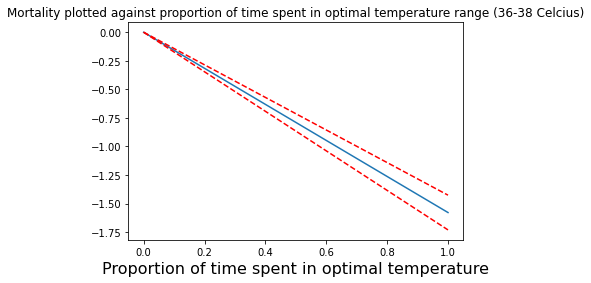

In [ ]:
from matplotlib import pyplot as plt
plt.figure();

XX = gam_within.generate_X_grid(term=0)
plt.plot(XX[:, 0], gam_within.partial_dependence(term=0, X=XX))
plt.plot(XX[:, 0], gam_within.partial_dependence(term=0, X=XX, width=.95)[1], c='r', ls='--')
plt.title("Mortality plotted against proportion of time spent in optimal temperature range (36-38 Celcius)")
plt.xlabel('Proportion of time spent in optimal temperature', fontsize=16)

Text(0.5, 1.0, 'yes')

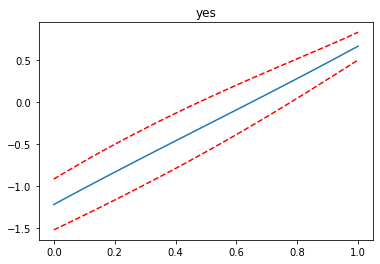

In [ ]:
from matplotlib import pyplot as plt
plt.figure();

XX = gam_above.generate_X_grid(term=0)
plt.plot(XX[:, 0], gam_above.partial_dependence(term=0, X=XX))
plt.plot(XX[:, 0], gam_above.partial_dependence(term=0, X=XX, width=.95)[1], c='r', ls='--')
plt.title("yes")

Text(0.5, 1.0, 'yes')

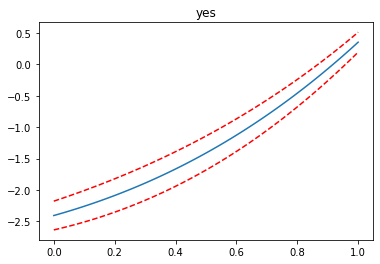

In [ ]:
from matplotlib import pyplot as plt
plt.figure();

XX = gam_below.generate_X_grid(term=0)
plt.plot(XX[:, 0], gam_below.partial_dependence(term=0, X=XX))
plt.plot(XX[:, 0], gam_below.partial_dependence(term=0, X=XX, width=.95)[1], c='r', ls='--')
plt.title("yes")